In [1]:
%load_ext autoreload

In [2]:
autoreload 2

In [24]:
import os
import sys
import time
import argparse
import datetime
import math
import pickle
from tqdm import tqdm as tqdm

import torchvision
import torchvision.transforms as transforms

import torch
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

from utils import DEVICE

Handle Data

In [16]:
valid_size = 0.1
batch_size = 32
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = torchvision.datasets.MNIST(
                root='../data', 
                train=True,
                download=True, 
                transform=transform)

test_data = torchvision.datasets.MNIST(
                root='../data', 
                train=False,
                download=True, 
                transform=transform)


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_size * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
                    train_data, 
                    batch_size=batch_size,
                    sampler=train_sampler,
                    num_workers=2)

valid_loader = torch.utils.data.DataLoader(
                    train_data, 
                    batch_size=batch_size, 
                    sampler=valid_sampler, 
                    num_workers=2)

test_loader = torch.utils.data.DataLoader(
                    test_data, 
                    batch_size=batch_size,
                    num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat',
 #          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = range(10)

(32, 1, 28, 28)


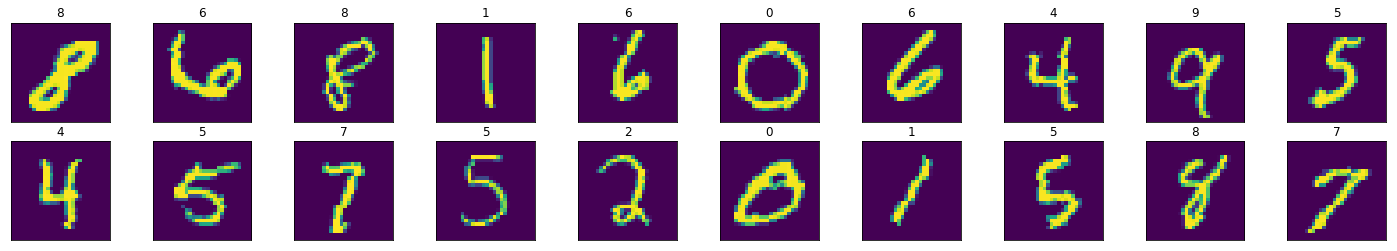

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

    # obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx][0])
    ax.set_title(classes[labels[idx]])

# Define Training functions

## Define how to train a frequentist model

In [34]:
def accuracy(outputs, labels, batch_size = batch_size):
    _, preds = outputs.max(1)
    correct = torch.eq(preds, labels).sum().item()
    return correct/batch_size

In [42]:
def test(model):
    test_accs = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            test_accs.append(accuracy(outputs, labels))
    return np.mean(test_accs)

In [35]:
def train(name, model, writer, n_epochs = 100):
    optimizer = optim.Adam(model.parameters())
    xent = nn.CrossEntropyLoss()
    model.train()
    m = len(train_loader)
    for epoch in tqdm(range(n_epochs)):
        history = dict(train_acc = [],
                      val_acc = [],
                      xent = [])
        
        # Train
        for batch_id, (images, labels) in enumerate(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            history['train_acc'].append(accuracy(outputs, labels))
            loss = xent(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            history['xent'].append(loss.item())
            
        #Validation
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                history['val_acc'].append(accuracy(outputs, labels))
                
        # Save values
        for key, values in history.items():
            writer.add_scalar('MNIST/{0}/{1}'.format(name, key),
                             np.mean(values), epoch)

## Define how to train a Bayesian Model

In [50]:
def bayes_train(name, model, writer, n_epochs = 100, n_samples = 2):
    model.train()
    m = len(train_loader)
    
    for epoch in tqdm(range(n_epochs)):
        history = dict(train_acc = [],
                       val_acc = [],
                       kl = [],
                       xent = [])
        
        # Train
        for batch_id, (images, labels) in enumerate(train_loader):
            beta = 2 ** (m - (batch_id + 1)) / (2 ** m - 1)
            #beta = 1/m
            
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = [model(images) for _ in range(n_samples)]
            kl, xe, loss = model.step(outputs, labels, beta)
            
            history['train_acc'].append(accuracy(outputs[0], labels))
            history['kl'].append(kl.item()/batch_size)
            history['xent'].append(xe.item()/batch_size)
            print('\rloss', xe.item(), end = '')
            
        #Validation
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                history['val_acc'].append(accuracy(outputs, labels))
                
        # Save values
        for key, values in history.items():
            writer.add_scalar('MNIST/{0}/{1}'.format(name, key),
                                 np.mean(values), epoch)

# Define and Train Models

In [51]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()
N_EPOCHS = 2
PI = 0.75
SIGMA_1 = np.exp(-1)
SIGMA_2 = np.exp(-6)

## Frequentist mlp

In [38]:
from utils import Flatten
mlp = lambda n_hidden: nn.Sequential(Flatten(28*28),
            nn.Linear(28*28, n_hidden),
            nn.Softplus(),
            nn.Linear(n_hidden, n_hidden),
            nn.Softplus(),
            nn.Linear(n_hidden, 10))

net = mlp(100)
name = 'MLP 100'

train(name, net, writer, n_epochs = N_EPOCHS)


100%|██████████| 2/2 [00:12<00:00,  6.33s/it]

## Bayesian MLP

In [52]:
from utils import ScaleMixtureGaussian
from bayes import BayesWrapper

prior_nll = ScaleMixtureGaussian(PI = PI,
                                 SIGMA_1 = SIGMA_1,
                                 SIGMA_2 = SIGMA_2)

bayesnet = BayesWrapper(name='BayesMLP 100',
                        net=mlp(100),
                        prior_nll = prior_nll)
bayes_train('Bayes MLP 100', bayesnet, writer, n_epochs = N_EPOCHS, n_samples =2)      


  0%|          | 0/2 [00:00<?, ?it/s]

loss 1.3006181716918945


 50%|█████     | 1/2 [00:24<00:24, 24.02s/it]

loss 0.26574915647506714


100%|██████████| 2/2 [00:55<00:00, 26.33s/it]

In [40]:
writer.export_scalars_to_json('all_scalars.json')

Test

In [53]:
print('Accuracy of the network on the 10000 test images: {:.2f} %'.format(
    100 * test(bayesnet)))


100%|██████████| 313/313 [00:02<00:00, 144.85it/s]

Accuracy of the network on the 10000 test images: 82.67 %
